# Notebook to do slide alignment between dapi and H&E (Adapted from Yoona again)

In [1]:
import SimpleITK as sitk
from skimage import filters
from sklearn.cluster import MeanShift

import pyvips
# from skimage.transform import resize, rescale
import PIL
from PIL import Image
import imutils
from scipy import ndimage
from scipy.ndimage import shift
from skimage.transform import rescale

import cv2

from glob import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

import os
import pathlib
from pathlib import Path
import warnings
from scipy.signal import fftconvolve

import tifffile

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
mpl.rcParams['pdf.fonttype'] = 42

sc._settings.settings._vector_friendly=True

In [2]:
# SimpleITK methods to align 2 images
# Returns the aligned image and saves the transformation
def command_iteration(method):
    """ Callback invoked when the optimization has an iteration """
    if method.GetOptimizerIteration() == 0:
        print("Estimated Scales: ", method.GetOptimizerScales())
    if method.GetOptimizerIteration() % 10 == 0:
        print(
            f"{method.GetOptimizerIteration():3} "
            + f"= {method.GetMetricValue():7.5f} "
            + f": {method.GetOptimizerPosition()}"
        )

def alignimgs(fixed, moving, savepth_md, snm='', verbose=True):

    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsCorrelation()
    R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                                minStep=1e-4,
                                                numberOfIterations=700,
                                                gradientMagnitudeTolerance=1e-8 )

    R.SetOptimizerScalesFromIndexShift()  

    tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity2DTransform())
    R.SetInitialTransform(tx) 
    R.SetInterpolator(sitk.sitkLinear)
    R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )

    outTx = R.Execute(fixed, moving)

    savenm = f'{savepth_md}/tfm_{snm}.hdf'
    sitk.WriteTransform(outTx, savenm)
    print('saved: ', savenm)

    if verbose:
        print("-------")
        print(outTx)
        print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
        print(" Iteration: {0}".format(R.GetOptimizerIteration()))
        print(" Metric value: {0}".format(R.GetMetricValue()))

    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed);
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(outTx)
    
    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2)

    nda = sitk.GetArrayFromImage(cimg)
      
    return nda

In [ ]:
# Functions from Yoona to do initial cropping of the H&E slide
# These are not used, we opt to manually crop since we only have 10 slides
# Also they don't always work and would require manual cropping anyways
def find_changes(y, wsize):
    changes = []
    n = int(np.ceil(len(y) / wsize))
    y0 = np.mean(y[0:wsize])
    for i in range(1, n):
        s = i*wsize
        f = (i+1)*wsize
        if i == n-1:
            f = len(y)
        mean_y = np.mean(y[s:f])
        slope = (mean_y - y0)/wsize
        if slope > 50:
            if len(changes) > 0:
                if s - changes[-1]  < 3*wsize:
                    changes.append(s)
            else:
                changes.append(s)
            

    return changes

def find_blocks(y, wsize):
    changes = []
    y0 = np.mean(y[0:wsize])
    n = int(np.ceil(len(y) / wsize))
    for i in range(1, n):
        s = i*wsize
        f = (i+1)*wsize
        if i == n-1:
            f = len(y)
        mean_y = np.mean(y[s:f])
        slope = (mean_y - y0)/wsize
        if slope > 10:
            changes.append(s)
            # if len(changes) > 0:
            #     print(s, slope)
            #     if s - changes[-1]  < 3*wsize:
            #         # print(s)
            #         # if i < 5:
            #         changes.append(s)
                    
            # else:
            #     print(s, slope)
            #     changes.append(s)
    
    slopes = []
    for j in range(1, len(changes)):
        slope = (changes[j] - changes[j-1])/wsize
        slopes.append(slope)
        
    ms = MeanShift(bandwidth=None, bin_seeding=True)
    ms.fit(np.reshape(slopes, (-1, 1)))
    
    labels = ms.labels_
    
    counts = np.bincount(labels)
    blk = np.argmax(counts)
    
    idx_blk = [changes[i] for i in np.where(labels == blk)[0]]

    return idx_blk



    
def crop_image(image, wsize=50, padding=75):
    """Crops an image to remove black borders."""

    # Get indices of non-zero elements
    # cols = np.where(image.sum(axis=0) > 2000)
    # rows = np.where(image.sum(axis=1) > 2000)

    cols = find_changes(image.sum(axis=0), wsize)
    if len(cols) < 15:   # this number needs to be changed based on wsize and slide size 
        cols = find_blocks(image.sum(axis=0), wsize)
            
    rows = find_blocks(image.sum(axis=1), wsize)
    if len(rows) < 15:   # this number needs to be changed based on wsize and slide size 
        rows = find_blocks(image.sum(axis=1), wsize)

    # Construct new array without zero spaces
    if np.min(rows) < padding:
        r0 = np.min(rows)
    else:
        r0 = np.min(rows) - padding

    if np.min(cols) < padding:
        c0 = np.min(cols)
    else:
        c0 = np.min(cols) - padding
    cropped_img= image[r0:np.max(rows) + wsize + padding, c0:np.max(cols) + wsize + padding]

    imgidx = pd.DataFrame({'x0':r0, 'xf':np.max(rows) + wsize + padding, 'y0':c0, 'yf':np.max(cols) + wsize + padding}, index=[0])
        
    return cropped_img, imgidx



In [4]:
# The main function that aligns the H&E to the dapi
# sid = slide name/index
# imgidx = cropping values for H&E
# pth_img = directory for H&E
# savepth_md = output directory for transformations

def doit(sid, imgidx, pth_img, savepth_md, savepth_img=None, verbose=True):
    if verbose:
        print(f'reading files for sample {sid} ...', end='')
        
    # read H&E image
    f_tiff = f'{pth_img}.tiff'
    image_he = tifffile.imread(f_tiff, is_ome = False, level = 5)    
    
    # Read DAPI image
    f_fix = f'/common/knottsilab/xenium/hpv/{sid}/morphology_focus/morphology_mip_level_6.png'
    image_mip = np.array(Image.open(f_fix))

    if verbose:
        print(' done')
    
    # Rescale and rotate the H&E to match the dapi (idk why we scale but Yoona did it in her code)
    arrm= rescale(image_he.astype('float32'), 0.6, anti_aliasing=False)[:,:,0]
    arrm_r = np.rot90(arrm)
    arrm_r = arrm_r.max() - arrm_r
    
    # Make initial plot
    if verbose:
        f, axs = plt.subplots(nrows=1, ncols=2)
        axs[0].imshow(image_mip, cmap='Blues')
        axs[0].set_title('DAPI Level 6')
        
        axs[1].imshow(arrm_r, cmap='Blues')
        axs[1].set_title('rotated H&E')
        plt.show()
    
    # first, to make the background to be zeros, use otsu thresholding method
    # get Otsu threshold 
    threshold = filters.threshold_otsu(arrm_r) 
    if verbose:
        print('otsu threshold is', threshold)
        
    arrm_r[arrm_r<=threshold] = 0
    
    # crop the image
    # cropping is weird since we scaled/rotated, probably a better way to do this
    arrm_rc = arrm_r[arrm_r.shape[0] - int(imgidx.x1*0.6):arrm_r.shape[0] - int(imgidx.x0*0.6), int(imgidx.y0*0.6):int(imgidx.y1*0.6)]
    
    # rescale and invert color back -- inverted color (background = 255) works best with simpleitk 
    arrm_rc *= (255.0/arrm_rc.max())
    arrm_rc = 255-arrm_rc
    
    arrf = image_mip * (255.0/np.max(image_mip))
    arrf = 255 - arrf
    
    # Plot the scaled/rotated H&E and dapi with colors inverted and thresholding applied to H&E
    if verbose:
        f, axs = plt.subplots(nrows=1, ncols=2)
        axs[0].imshow(arrf, cmap='Blues')
        axs[0].set_title('DAPI Level 6')
        
        axs[1].imshow(arrm_rc, cmap='Blues')
        axs[1].set_title('rotated/filtered H&E')
        plt.show()
    
    moving= sitk.GetImageFromArray(arrm_rc.astype('float32'))
    fixed = sitk.GetImageFromArray(arrf.astype('float32'))
        
    nda = alignimgs(fixed, moving, savepth_md, sid.split('/')[1], verbose=False)

    # Plot the aligned images overlaid (DAPI in red, H&E in blue?)
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
    ax.imshow(nda[:,:,1], cmap='Blues_r')
    ax.imshow(nda[:,:,0], cmap='Reds_r', alpha=0.5)
    #ax.imshow(nda[:,:,0], cmap='Greens_r', alpha=0.5)
    ax.set_axis_off()
    plt.title(sid)
    if savepth_img is not None:
        plt.savefig(f'{savepth_img}/{sid}_aligned.png')
    plt.show()

    return nda

In [5]:
# Dictionary to get the h&e slide names from the xenium output name
anno_dict = {
    '20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651': 'ag_hpv_01',
    '20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060077__Region_1__20250213__202651': 'ag_hpv_02',
    '20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922': 'ag_hpv_04',
    '20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060367__Region_1__20250224__233922': 'ag_hpv_03',
    '20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0059911__Region_1__20250304__005817': 'ag_hpv_06',
    '20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0060395__Region_1__20250304__005817': 'ag_hpv_05',
    '20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060364__Region_1__20250305__223715': 'ag_hpv_08',
    '20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060366__Region_1__20250305__223715': 'ag_hpv_07',
    '20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG00206__0060488__Region_1__20250312__004017': 'ag_hpv_09',
    '20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG00206__0060493__Region_1__20250312__004017': 'ag_hpv_10'
}

In [6]:
slides = list(anno_dict.keys())
slides

['20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651',
 '20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060077__Region_1__20250213__202651',
 '20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922',
 '20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060367__Region_1__20250224__233922',
 '20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0059911__Region_1__20250304__005817',
 '20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0060395__Region_1__20250304__005817',
 '20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060364__Region_1__20250305__223715',
 '20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060366__Region_1__20250305__223715',
 '20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG00206__0060488__Region_1__20250312__004017',
 '20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG002

In [7]:
# H&E slides have a lot of empty space on the boarder
# Cropping helps the alignment
recrop = False # If a core has been cropped keep the existing value

# Use existing cropping coordinates if they exist
if os.path.exists('/common/lamt2/HPV/data/xenium/alignment/cropped_slides.csv'):
    df_idx = pd.read_csv('/common/lamt2/HPV/data/xenium/alignment/cropped_slides.csv', index_col = 0)
else:
    df_idx = pd.DataFrame(columns = ['x0', 'x1', 'y0', 'y1'])

# This code is similar to the corebycore cropping done earlier
for s in slides:
    if s in df_idx.index and not recrop:
        print(f'Slide {s} already cropped')
        continue
    else:
        tif = tifffile.imread(f'/common/knottsilab/xenium/hpv/svs/{anno_dict[s]}.tiff', is_ome = False, level = 5)
        plt.imshow(tif, origin = 'lower')
        plt.title(s)
        plt.show()
        x0 = 0
        x1 = tif.shape[1]
        y0 = 0
        y1 = tif.shape[0]
        ispass = 'n'
        while ispass != 'y':
            ispass = input('Is pass? [y]/n/quit') or 'y'
            if ispass == 'quit':
                break
            if ispass != 'y':
                newidx = input(f'New coords (current = {x0}, {str(tif.shape[1])+"*" if x1 >= tif.shape[1] else x1}, {y0}, {str(tif.shape[0])+"*" if y1 >= tif.shape[0] else y1}): ') or f'{x0}, {x1}, {y0}, {y1}'
                x0, x1, y0, y1 = [int(a) for a in newidx.split(',')]
                x1 = min(x1, tif.shape[1])
                y1 = min(y1, tif.shape[0])
                plt.imshow(tif[y0:y1, x0:x1], origin = 'lower')
                plt.title(s)
                plt.show()
        plt.close()
        if s not in df_idx.index:
            img_idx = pd.DataFrame({'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1}, index = [s])
            df_idx = pd.concat([df_idx, img_idx])
        else:
            df_idx.loc[s] = {'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1}


Slide 20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651 already cropped
Slide 20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060077__Region_1__20250213__202651 already cropped
Slide 20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922 already cropped
Slide 20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060367__Region_1__20250224__233922 already cropped
Slide 20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0059911__Region_1__20250304__005817 already cropped
Slide 20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0060395__Region_1__20250304__005817 already cropped
Slide 20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060364__Region_1__20250305__223715 already cropped
Slide 20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060366__Region_1__20250305__223715 already cropped
Slide 20250312__0039

In [8]:
df_idx

,x0,x1,y0,y1
20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651,1400,4400,200,1800
20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060077__Region_1__20250213__202651,1500,4300,250,1650
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060354__Region_1__20250224__233922,1200,4050,700,2050
20250224__233848__X206_2242025_ANOGENTMA_03_04/output-XETG00206__0060367__Region_1__20250224__233922,1400,4400,500,2000
20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0059911__Region_1__20250304__005817,325,3100,300,1650
20250304__005745__X403_03032025_ANOGENTMA_05_06/output-XETG00403__0060395__Region_1__20250304__005817,350,3100,300,1700
20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060364__Region_1__20250305__223715,250,3100,275,1700
20250305__223640__X206_03052025_HPVTMA_01_02/output-XETG00206__0060366__Region_1__20250305__223715,350,3100,275,1700
20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG00206__0060488__Region_1__20250312__004017,250,3150,250,1700
20250312__003942__X206_03112025_HPVTMA_03_04/output-XETG00206__0060493__Region_1__20250312__004017,1700,4000,350,1700


In [ ]:
# Save the cropping coordinates
df_idx.to_csv('/common/lamt2/HPV/data/xenium/alignment/cropped_slides.csv')

In [9]:
# Directory where we save the transformations
savepth_md = '/common/lamt2/HPV/data/xenium/alignment/aligned_slides/'

20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651/morphology_mip_level_6.png is saved
reading files for sample 20250213__202616__X206_02132025_ANOGENTMA_1_2/output-XETG00206__0060075__Region_1__20250213__202651 ... done


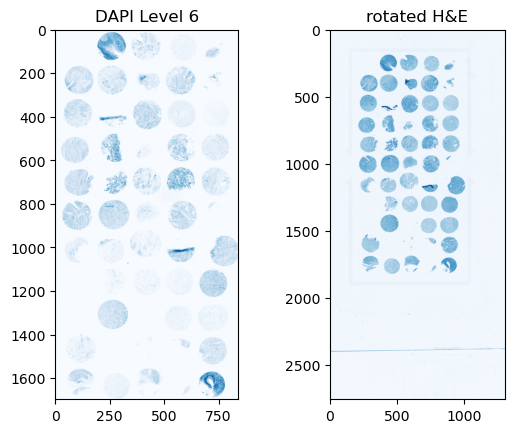

otsu threshold is 50.31883


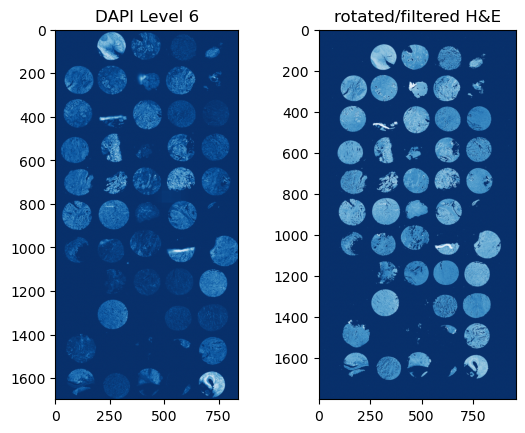

Estimated Scales:  (904076.3584902172, 904068.8245456681, 0.999999999998181, 0.999999999998181)
  0 = -0.23816 : (0.9997163071223818, -0.0004006198184543677, 58.13619300857871, 53.730482947772124)
 10 = -0.51563 : (0.9682373247618019, -0.0016738315052997534, 50.900073289628054, 35.47941196947951)
 20 = -0.65450 : (0.9703445343237371, -0.0020384039019631004, 50.809785608033685, 35.283755266479886)
 30 = -0.65452 : (0.9703412189921256, -0.0020371880090979504, 50.81544844460704, 35.31125425235726)
saved:  /common/lamt2/HPV/data/xenium/alignment/aligned_slides//tfm_output-XETG00206__0060075__Region_1__20250213__202651.hdf


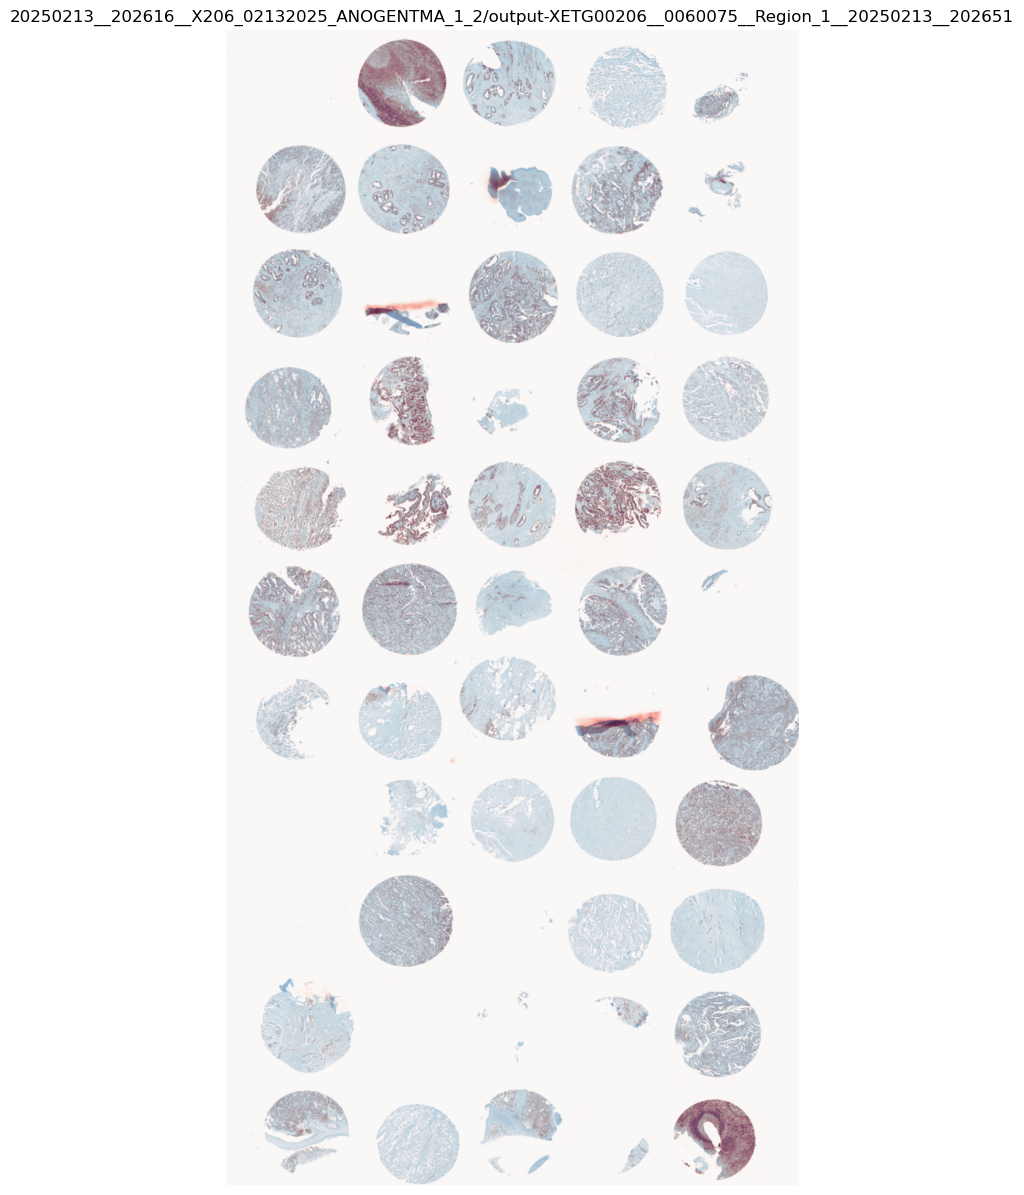

In [ ]:
LEVEL = 6
# for s in slides:
for s in slides[:1]: # Just the first one for visualization
    
    # Save DAPI level 6 as a png to use for alignment
    f_fix = f'/common/knottsilab/xenium/hpv/{s}/morphology_focus/morphology_focus_0000.ome.tif'
    image_mip = tifffile.imread(f_fix, is_ome = False, level = LEVEL)
        
    im = Image.fromarray(image_mip)
    im.save(f'/common/knottsilab/xenium/hpv/{s}/morphology_focus/morphology_mip_level_{LEVEL}.png')

    print(f'{s}/morphology_mip_level_{LEVEL}.png is saved')
    
    # Run the alignment
    doit(s, df_idx.loc[s], f'/common/knottsilab/xenium/hpv/svs/{anno_dict[s]}', savepth_md)
    # doit() has 4 outputs:
    #    1) DAPI and rotated H&E side by side
    #    2) Inverted dapi and rotated+scaled+cropped H&E side by side
    #    3) SimpleITK output (idk exactly what this means but it's related to the alignment transformation)
    #    4) dapi (red) and aligned H&E overlaid (blue)
    plt.show()